# **Final project for the Digital Signal and Image processing exam**

**Task:** Design and implement a Kalman filter for tracking a spacecraft which moves with constant acceleration

The project was created by Vasilii Tregubov (student_id: 6131225), email: tregubovvg@gmail.com

In [38]:
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random as r
import math

# **Introduction. Apollo 12 welcomes you!**

This project implements a Kalman filter to predict the position of a spacecraft moving in space with constant acceleration and sending signals to the "mission control center". To make the presentation even more beautiful, we will call this ship "Apollo 12", which travels from planet Earth to Mars (although the model parameters, of course, are adjusted to any possible direction between any possible points in three-dimensional space).

The first section will describe the mathematical apparatus created by the author to calculate the trajectory along which the spaceship moves, according to a given task. The second describes the implementation of the Kalman filter for constantly accelerated motion in three-dimensional space. The third provides assessments and conclusions about the quality of the model.

# **Classic mechanic power**
We consider motion in which the acceleration vector $\overline{a}$ in 3-dimensional Euclidean space is constant and the equation of motion can be written as:
$$\overline{a}(t) = \overline{a},$$
we neglect relativistic effects and the presence of other massive objects in space. Integrating this equation over time $t$ we obtain the equation for the velocity vector:
$$\overline{v}(t) = \overline{v}_0 + \overline{a}t,$$
by re-integrating which, we obtain the vector displacement equation:
$$\overline{r} = \overline{r}_0 + \overline{v}_0t + \frac{\overline{a}t^2}{2},$$

where $\overline{r}_0 = \{x_{r_0}, y_{r_0}, z_{r_0} \}^T$ is the vector of the original direction, $\overline{v}_0 = \{x_{v_0}, y_{v_0}, z_{v_0} \}^T -$ is the vector of the original velocity and $\overline{a} = \{x_{a}, y_{a}, z_{a} \}^T$ is the constant vector of the acceleration.

Assuming that $t_0 = 0$ is the start time of the journey, knowing the start coordinates, the time $t_1$ required to complete the trip, as well as the end coordinates and formally creating a third random point of the trajectory, we can uniquely determine all parameters $\overline{r}_0, \overline{v}_0, \overline{a}.$

$\textbf{N.B.}$ The creation of a third implicit point of the trajectory is necessary from a geometric point of view, since the displacement equation is an equation of a second-order curve (a parabola, to be precise), for which, according to the well-known theorem, three points are necessary and sufficient to uniquely determine. From an algorithmic point of view, this approach guarantees the generation of a “slightly” different trajectory each time the algorithm is re-runing.

In order to calculate all parameters it is necessary to solve the system of the matrix equations:
$$T \times \textbf{t}_i = X_i,$$
where $T$ is the matrix of the parabola's coefficents, $\textbf{t} = \{t^2, t, 1\}$ and $X_i -$ coordinates of start, associated with $t = 0$, coordinates of end, associated with $t = t_1$ and an random point, associated with $t = t_{rand} > t_1$.

In [39]:
#Ideal parabolic trajectory

# time-features space function
def prblc_time_ftrs_vr(time):
  tv = np.array([time**2,time,1])
  return tv

# Solving system of the parabola equations
def find_parabola_parameters(point0, point1, point2, dimension):
    c = point0[dimension]
    T = np.array([prblc_time_ftrs_vr(point1[3]),prblc_time_ftrs_vr(point2[3]),[0,0,1]])
    X = np.array([point1[dimension],point2[dimension],c]).reshape(-1, 1)
    # Solve the system of equations
    parameters = np.linalg.solve(T, X)
    a = float(parameters[0])*2
    b = float(parameters[1])
    c = float(parameters[2])
    return a,b,c

# Function which generate parameters of the parabola
def prbl_trctry_mx(point0, point1, point2):
  S = []
  for i in range(3):
      a,b,c = find_parabola_parameters(point0, point1, point2, i)
      S_i = [a,b,c]
      S.append(S_i)
  S = np.array(S)
  return(S)

# Function which generate massive of trajectory points and coefficients matrix
def prbl_trctry_cords(point0, point1, t):
    point2 = point1 + np.array([r.randint(1000,10000), r.randint(1000,10000), r.randint(1000,10000), 1])
    S = prbl_trctry_mx(point0, point1, point2)
    x = t**2 * S[0][0] / 2 + t * S[0][1] + S[0][2]
    y = t**2 * S[1][0] / 2 + t * S[1][1] + S[1][2]
    z = t**2 * S[2][0] / 2 + t * S[2][1] + S[2][2]
    return x, y, z, S

In [40]:
# Parameters of the journey

# Planet 1 (Earth)
radius1 = 6371
center1 = np.array([0, 0, 0])

# Start-point of the journey
point0 = np.array([center1[0], center1[1], center1[2] + radius1, 0])

# Distance (km)
Distance = 55.76 * 10**(6)

# Duration (hours)
end_hour = 2000

# Planet 2 (Mars)
radius2 = 3389.5
xc2 = yc2 = zc2 = Distance / math.sqrt(3)
center2 = np.array([xc2, yc2, zc2])

# End-point of the journey
point1 = np.array([xc2 - radius2, yc2, zc2, end_hour])

In [41]:
#Creating an ideal parabolic trajectory

# Create data points for the surface of Earth
phi1, theta1 = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
x1 = radius1*np.sin(theta1)*np.cos(phi1) + center1[0]
y1 = radius1*np.sin(theta1)*np.sin(phi1) + center1[1]
z1 = radius1*np.cos(theta1) + center1[2]

# Create data points for the surface of Mars
phi2, theta2 = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
x2 = radius2*np.sin(theta2)*np.cos(phi2) + center2[0]
y2 = radius2*np.sin(theta2)*np.sin(phi2) + center2[1]
z2 = radius2*np.cos(theta2) + center2[2]

# Create a parameter t
t = np.linspace(0, end_hour, (end_hour+1)*60)

# Trajectory of a parabola
x_id, y_id, z_id, S = prbl_trctry_cords(point0, point1, t)

# Initial coordates
x0 = np.array([S[0][2], S[1][2], S[2][2]])

# Initial velocity
v0 = np.array([S[0][1], S[1][1], S[2][1]])
v0_value = math.sqrt(v0[0]**2+v0[1]**2+v0[2]**2)

#Acseleration
a = np.array([S[0][0], S[1][0], S[2][0]])
a_value = math.sqrt(a[0]**2+a[1]**2+a[2]**2)

# Some mean values in addition
x_id_mean = x_id.mean()
y_id_mean = y_id.mean()
z_id_mean = z_id.mean()

Hi, Huston! Its Appollo-12 and we have just started our journey to Mars!

Information about the journey
Distance: 55760000.0 km
Duration: 2000 h or  83.0 days (in approximation)
Initial velocity: 50101.0 km / h or  14.0 km / sec
Acceleration: 22.0 km / h^2

Initial parameters
Coordinates: [   0.    0. 6371.]
Vector of the velocity: [30542. 28094. 28071.]
Vector of the acceleration: [-14. -12. -12.]



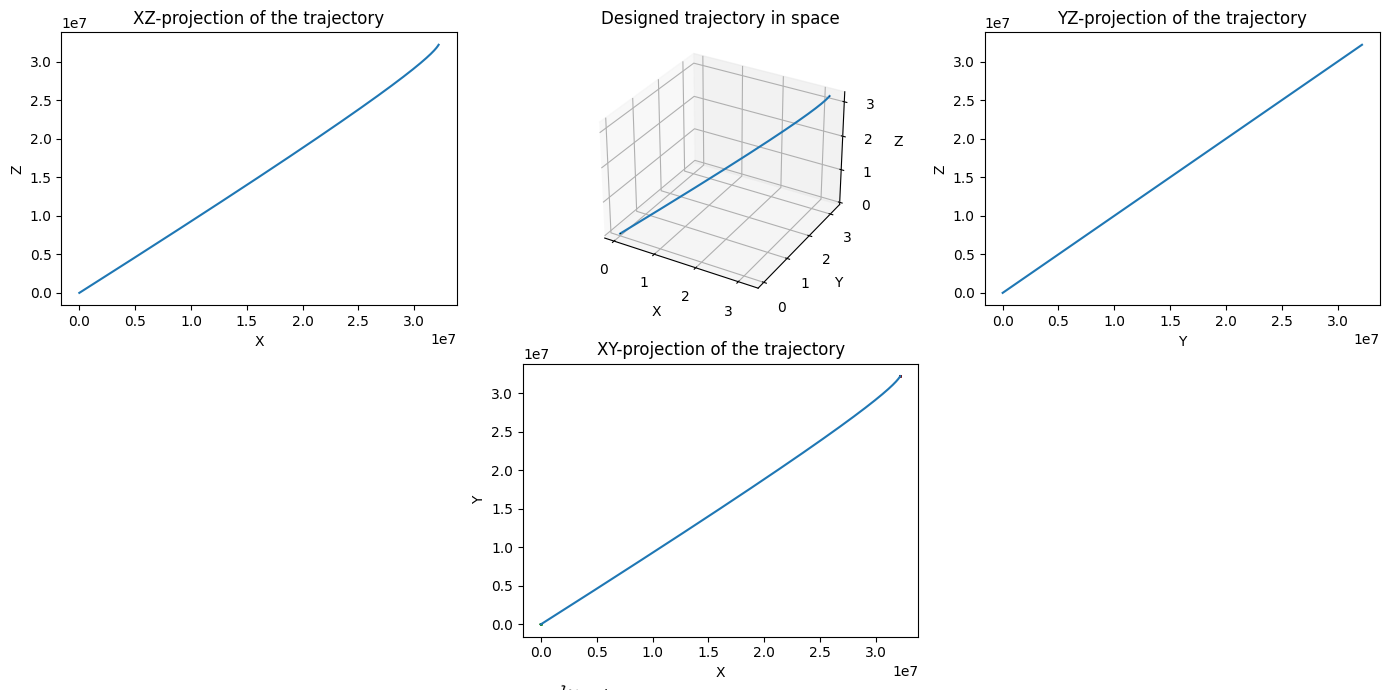

In [42]:
# Ploting our ideal (or designed for journey) trajectory

# If you want, you can zoom plots and see not only points of start and end, but schematical surface of planets!
# For simplicity spaceship is launched from North Pole.

# XYZ plot
fig = plt.figure(figsize=(14, 7))
ax_xyz = fig.add_subplot(232, projection='3d')
ax_xyz.set_xlabel('X')
ax_xyz.set_ylabel('Y')
ax_xyz.set_zlabel('Z')
ax_xyz.plot_surface(x1, y1, z1, color='forestgreen', alpha=0.6)
ax_xyz.plot_surface(x2, y2, z2, color='maroon', alpha=0.6)
ax_xyz.plot(x_id, y_id, z_id, label='Designed trajectory')
plt.title('Designed trajectory in space')
# XZ plot
ax_xz = fig.add_subplot(231)
ax_xz.set_xlabel('X')
ax_xz.set_ylabel('Z')
ax_xz.plot(x1, z1, color='forestgreen', alpha=0.6)
ax_xz.plot(x2, z2, color='maroon', alpha=0.6)
ax_xz.plot(x_id, z_id, label='Designed trajectory')
plt.title('XZ-projection of the trajectory')
# ax_xz.legend()
# YZ plot
ax_yz = fig.add_subplot(233)
ax_yz.set_xlabel('Y')
ax_yz.set_ylabel('Z')
ax_yz.plot(y1, z1, color='forestgreen', alpha=0.6)
ax_yz.plot(y2, z2, color='maroon', alpha=0.6)
ax_yz.plot(y_id, z_id, label='Designed trajectory')
plt.title('YZ-projection of the trajectory')
# ax_yz.legend()
# XY plot
ax_xy = fig.add_subplot(235)
ax_xy.set_xlabel('X')
ax_xy.set_ylabel('Y')
ax_xy.plot(x1, y1, color='forestgreen', alpha=0.6)
ax_xy.plot(x2, y2, color='maroon', alpha=0.6)
ax_xy.plot(x_id, y_id, label='Designed trajectory')
plt.title('XY-projection of the trajectory')
# ax_xy.legend()

print('Hi, Huston! Its Appollo-12 and we have just started our journey to Mars!')
print('')
print('Information about the journey')
print('Distance:', Distance, 'km')
print('Duration:', end_hour, 'h or ', np.round(end_hour / 24), 'days (in approximation)')
print('Initial velocity:', np.round(v0_value), 'km / h or ', np.round(v0_value/60/60), 'km / sec')
print('Acceleration:', np.round(a_value), 'km / h^2')
print('')
print('Initial parameters')
print('Coordinates:',np.round(x0,0))
print('Vector of the velocity:',np.round(v0))
print('Vector of the acceleration:',np.round(a))
print('')

plt.tight_layout()
plt.show()

# **Linear models of the process and observation**
*Abracadabra bursts out with a noise, — Joseph Brodsky*

The ideal flight path that we have designed is just a preparation for simulating the Kalman process. It is obvious that in reality, the trajectory of the spacecraft cannot be ideal, due to the presence of external influence of some intensity. To take this into account, let’s introduce a little white noise (or process noise, in terms of the Kalman theory) into our model and build a linear model of motion, which is described by equation:
$$s_{k+1} = \Phi s_k + q_k,$$
$$ \Phi =
\begin{bmatrix}
1 & 1 & \frac{1}{2} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & \frac{1}{2} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & \frac{1}{2} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix},$$
where $s_k = \{x_{k},v_{x_k},a_x,\ldots,a_z\}$, $q_k = \{q_{1,k},q_{2,k},\ldots,q_{9,k}\}$ is the process noise and $k$ is an itearion of system, which increases in our model every minute. Covariance matrix of the process noise will be defined as $Q$.

The second (and key) linear model is the observation model, which in our example represents the readings of the spacecraft about its position, which are received by our mission control center. To model these readings, we will assume that the spacecraft sends data about its position $m_k$ every k-moment with a constant error $r_k$, maintaining its variance and average equal to 0 (another white noise). For creation the following equation will be used:
$$m_k = H s_k + r_k,$$
$$H =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
\end{bmatrix}$$
and covariance $3 \times 3$ matrix of the measurement noise $R$ will be defined.

In [43]:
# Function for creating white noise with a "range" equal to a percentage of the data value
def w_noise(a, perc):
  q = (r.random()*2-1)*np.abs(a)*(perc/100)
  return q

# Covariance matrix of the noise
def cov_matrix(q):
  len = q.shape[0]
  Q = q[0] @ q[0].T
  for k in range(1,len):
    Q = Q + q[k] @ q[k].T
  Q = Q / len
  return Q

In [44]:
# Parameters of the model

# Level of process noise in the model (perc of mean values of the parameters)
pr_noise_perc = 0.01

# Level of measurement noise in the model (greater perc of mean values of the parameters)
mm_noise_perc = 0.13

In [45]:
# Linear proccess model implementation

# Transition matrix
Ф = np.array([
[1,1,0.5,0,0,0,0,0,0],
[0,1,1,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0],
[0,0,0,1,1,0.5,0,0,0],
[0,0,0,0,1,1,0,0,0],
[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,1,0.5],
[0,0,0,0,0,0,0,1,1],
[0,0,0,0,0,0,0,0,1]])

# Initial state of the system
S0 = np.array([x0[0], v0[0], a[0], x0[1], v0[1], a[1], x0[2], v0[2], a[2]]).reshape(-1,1)

# Calculating real trajectory parameters
S = [S0]
q = []
for k in range(len(t)):
  k = int(k)
  qk = np.array([w_noise(x_id_mean, pr_noise_perc),w_noise(v0_value, pr_noise_perc),w_noise(a_value, pr_noise_perc),
                 w_noise(y_id_mean, pr_noise_perc),w_noise(v0_value, pr_noise_perc),w_noise(a_value, pr_noise_perc),
                 w_noise(z_id_mean, pr_noise_perc),w_noise(v0_value, pr_noise_perc),w_noise(a_value, pr_noise_perc)]).reshape(-1,1)
  Xkp1 = Ф @ S[k] + qk
  q.append(qk)
  S.append(Xkp1)
S = np.array(S)
q = np.array(q)

# Process noise covariance matrix
Q = cov_matrix(q)

# Logging real trajectory coordinates
x_real = []
y_real = []
z_real = []
for k in range(len(t)):
  k = int(k)
  xk = S[k][0]
  yk = S[k][3]
  zk = S[k][6]
  x_real.append(xk)
  y_real.append(yk)
  z_real.append(zk)

x_real = np.array(x_real)
y_real = np.array(y_real)
z_real = np.array(z_real)

In [46]:
# Linear observation model

# Measurement matrix
H = np.array([
    [1,0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0]])

m = []
r_noise = []
for k in range(len(t)):
  rk = np.array([w_noise(x_id_mean, mm_noise_perc),
                 w_noise(y_id_mean, mm_noise_perc),
                 w_noise(z_id_mean, mm_noise_perc)]).reshape(-1,1)
  k = int(k)
  mk = H @ S[k] + rk
  m.append(mk)
  r_noise.append(rk)

m = np.array(m)
r_noise = np.array(r_noise)

#Measurment noise covariance matrix
R = cov_matrix(r_noise)

x_obs = []
y_obs = []
z_obs = []
for k in range(len(t)):
  k = int(k)
  xk = m[k][0]
  yk = m[k][1]
  zk = m[k][2]
  x_obs.append(xk)
  y_obs.append(yk)
  z_obs.append(zk)

# **Kalman filtering (finally!)**
Now we are ready to implement the Kalman algorithm and predict the optimal position of the spacecraft based on the received signals! We have the sensor readings, transition matrices, covariances of process noise and measurement noise. The Kalman algorithm is defined by the recurrent equation:
$$p_k = p^-_k + K_k(m_k - H p^-_k)$$
where $K_k$ is the Kalman gain, $p^-_k = \Phi p_{k-1}$.

$\textbf{N.B.}$ We use $p_k$-notation for estimated values of $s_k$ instead of $s_k$ with hat just for convenience of typing formulas.

Kalman gain is the matrix of coefficients, which regularises preference between the linear prediction and the received signal. It's calculated from squared error minimization and has exact recurent formula:
$$K_k = P^-_kH^T(HP^-_kH^T + R)^{-1},$$

where $P_k$ is posterior covarance matrix and $P_k^- = \Phi P_{k-1} \Phi^T+Q \ -$ covariance estimate projection.

At first we need to inicialize $p_0$ and $P_0$. Since this requires only a random point we can use for $p_0 = s_0 + q$ (just actual start + some noise again), hense $p^-_1 = \Phi p_0$. Error of the first state is $e_0 = s_0 - p_0$, posterior covariance matrix is just $P_0 = e_0 e_0^T$ and covariance estimate projection is $P_1^- = \Phi P_{0} \Phi^T+Q$.

After that we repeat these steps:
1. Set the Kalman gain $K_k$.
2. Update state $p_k$.
3. Calculate covariance update $P_k$.
4. Make state estimate projection $p_{k+1}^-$.
5. Make covariance estimate projection $P_{k+1}^-$.
6. $k+1 → k$.

In [47]:
# Calculation of the MSE
def mse(actual, pred):
 actual, pred = np.array(actual), np.array(pred)
 return np.square(np.subtract(actual,pred)).mean()

In [48]:
#Semi-random initial state (real + process noise)
s0_est = S[0] + np.array([w_noise(x_id_mean, pr_noise_perc),w_noise(v0_value, pr_noise_perc),w_noise(a_value, pr_noise_perc),
                 w_noise(y_id_mean, pr_noise_perc),w_noise(v0_value, pr_noise_perc),w_noise(a_value, pr_noise_perc),
                 w_noise(z_id_mean, pr_noise_perc),w_noise(v0_value, pr_noise_perc),w_noise(a_value, pr_noise_perc)]).reshape(-1,1)

#Initial error vector
e0 = S[0] - s0_est

#Initial posterior covariance
P0 = e0 @ e0.T

In [49]:
# Kalman algorithm

#Initial projections
sk_est_ = Ф @ s0_est
Pk_ = Ф @ P0 @ Ф.T + Q

#Algorithm
S_est = [s0_est]
K = []
for k in range(1,len(t)):
  #Kalman gain
  Kk = Pk_ @ H.T @ np.linalg.inv(H @ Pk_ @ H.T + R)
  # Update
  sk_est = sk_est_ + Kk @ (m[k] - H @ sk_est_)
  Pk = (np.eye(9) - Kk @ H) @ Pk_
  #Projection
  sk_est_ = Ф @ sk_est
  Pk_ = Ф @ Pk @ Ф.T + Q
  #Logging estimated values
  S_est.append(sk_est)
  K.append(Kk)

S_est = np.array(S_est)
K = np.array(K)

#Saving estimated coordinates
x_est = []
y_est = []
z_est = []
for k in range(len(t)):
  k = int(k)
  xk = S_est[k][0]
  yk = S_est[k][3]
  zk = S_est[k][6]
  x_est.append(xk)
  y_est.append(yk)
  z_est.append(zk)

#Calculation of the mean values of the K_k-matrices for checking stabilization of K
K_means = []
for k in range(len(K)):
  Kk = K[k].mean()
  K_means.append(Kk)

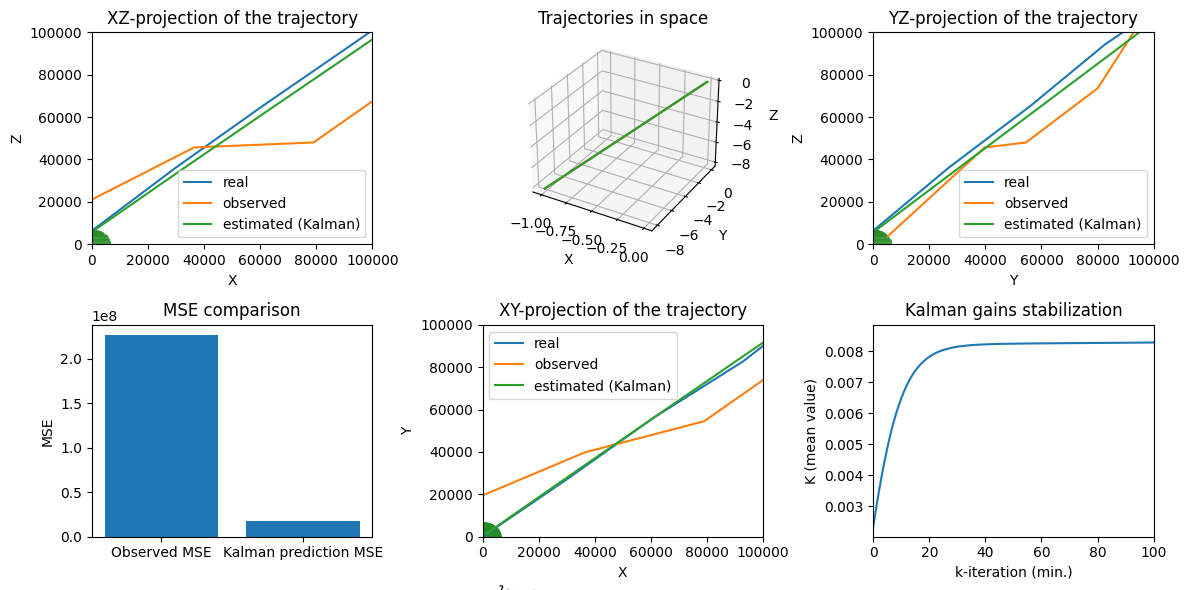

In [50]:
#Plotting results

#Scale for projection-plots (for seeing result of Kalman process in details!)
min = 0
max = 100000

# XYZ plot
fig = plt.figure(figsize=(12, 6))
ax_xyz = fig.add_subplot(232, projection='3d')
ax_xyz.set_xlabel('X')
ax_xyz.set_ylabel('Y')
ax_xyz.set_zlabel('Z')
ax_xyz.plot_surface(x1, y1, z1, color='forestgreen', alpha=0.6)
ax_xyz.plot_surface(x2, y2, z2, color='maroon', alpha=0.6)
ax_xyz.plot(x_real, y_real, z_real, label='real')
ax_xyz.plot(x_obs, y_obs, z_obs, label='observed')
ax_xyz.plot(x_est, y_est, z_est, label='estimated (Kalman)')
plt.title('Trajectories in space')
# XZ plot
ax_xz = fig.add_subplot(231)
ax_xz.set_xlabel('X')
ax_xz.set_ylabel('Z')
ax_xz.plot(x1, z1, color='forestgreen', alpha=0.6)
ax_xz.plot(x2, z2, color='maroon', alpha=0.6)
ax_xz.plot(x_real, z_real, label='real')
ax_xz.plot(x_obs, z_obs, label='observed')
ax_xz.plot(x_est, z_est, label='estimated (Kalman)')
ax_xz.legend()
plt.title('XZ-projection of the trajectory')
plt.xlim(min,max)
plt.ylim(min,max)
# YZ plot
ax_yz = fig.add_subplot(233)
ax_yz.set_xlabel('Y')
ax_yz.set_ylabel('Z')
ax_yz.plot(y1, z1, color='forestgreen', alpha=0.6)
ax_yz.plot(y2, z2, color='maroon', alpha=0.6)
ax_yz.plot(y_real, z_real, label='real')
ax_yz.plot(y_obs, z_obs, label='observed')
ax_yz.plot(y_est, z_est, label='estimated (Kalman)')
ax_yz.legend()
plt.title('YZ-projection of the trajectory')
plt.xlim(min,max)
plt.ylim(min,max)
# XY plot
ax_xy = fig.add_subplot(235)
ax_xy.set_xlabel('X')
ax_xy.set_ylabel('Y')
ax_xy.plot(x1, y1, color='forestgreen', alpha=0.6)
ax_xy.plot(x2, y2, color='maroon', alpha=0.6)
ax_xy.plot(x_real, y_real, label='real')
ax_xy.plot(x_obs, y_obs, label='observed')
ax_xy.plot(x_est, y_est, label='estimated (Kalman)')
ax_xy.legend()
plt.title('XY-projection of the trajectory')
plt.xlim(min,max)
plt.ylim(min,max)
# MSE plot
ax_bar = fig.add_subplot(234)
ax_bar.set_ylabel('MSE')
obs_mse = mse(y_real,y_obs)
est_mse = mse(y_real,y_est)
ax_bar.bar(['Observed MSE','Kalman prediction MSE'],[obs_mse,est_mse])
plt.title('MSE comparison')

#Kk mean values plot
ax_K = fig.add_subplot(236)
ax_K.set_xlabel('k-iteration (min.)')
ax_K.set_ylabel('K (mean value)')
ax_K.plot(K_means)
plt.xlim(0,100)
plt.title('Kalman gains stabilization')

plt.tight_layout()
plt.show()

# **Сonclusions**
The main goal of this project has been achieved: We implemented the Kalman algorithm for the case of constantly accelerated motion in three-dimensional space. We see that the algorithm produces a stable forecast, the mean square error of which is approximately 13 times less than that of the data coming from the spacecraft, and the forecast line is a smoothly evolving curve.

With its help, our Apollo 12 has successfully landed on Mars!

The Kalman filter is an excellent algorithm for filtering, and one might even say the best, since it is possible to prove that the average squared error of the filter is minimal.

The project was created by Vasilii Tregubov (student_id: 6131225), email: tregubovvg@gmail.com